# Regression of Used Car Prices Dataset
Run after following notebooks are run:
1. **01_Data_Cleaning**
2. **02_EDA**

## Development Notes/Ideas
- ~~rf~~ - cannot use as would have to OHE
- ~~xgb~~ - cannot use as would have to OHE
- lightgbm
- catboost
- stack


## Libraries

In [1]:
## set up libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap
from sklearn.model_selection import StratifiedKFold

## Load Data

In [2]:
train = pd.read_pickle('train_fe.pkl')
test = pd.read_pickle('test_fe.pkl')

## separate in to features and response variable
x_train = train.drop('price', axis=1)
y_train = train['price']

x_test = test

## Modelling

In [3]:
## instantiate rf algorithm, using 
lgbm = lgb.LGBMRegressor(n_estimators=300, seed=888, n_jobs=-1)

## fit model to training data
lgbm.fit(x_train, y_train, categorical_feature='auto')

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30410
[LightGBM] [Info] Number of data points in the train set: 192542, number of used features: 65
[LightGBM] [Info] Start training from score 43892.074270


LGBMRegressor(n_estimators=300, n_jobs=-1, seed=888)

In [17]:
## cross validation
dataset_train = lgb.Dataset(x_train, label=y_train)
params = {'n_estimators':300}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=888)

lgbm_cv = lgb.cv(train_set=dataset_train, params=params, folds=kf, metrics='rmse'); None
print('\n cv rmse:', lgbm_cv['valid rmse-mean'][-1])

c:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:738: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


c:\Users\steph\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30410
[LightGBM] [Info] Number of data points in the train set: 154033, number of used features: 65
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30410
[LightGBM] [Info] Number of data points in the train set: 154033, number of used features: 65
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30410
[LightGBM] [Info] Number of data points in the train set: 154034, number of used features: 65
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026890 seconds.
You can set `force_col_

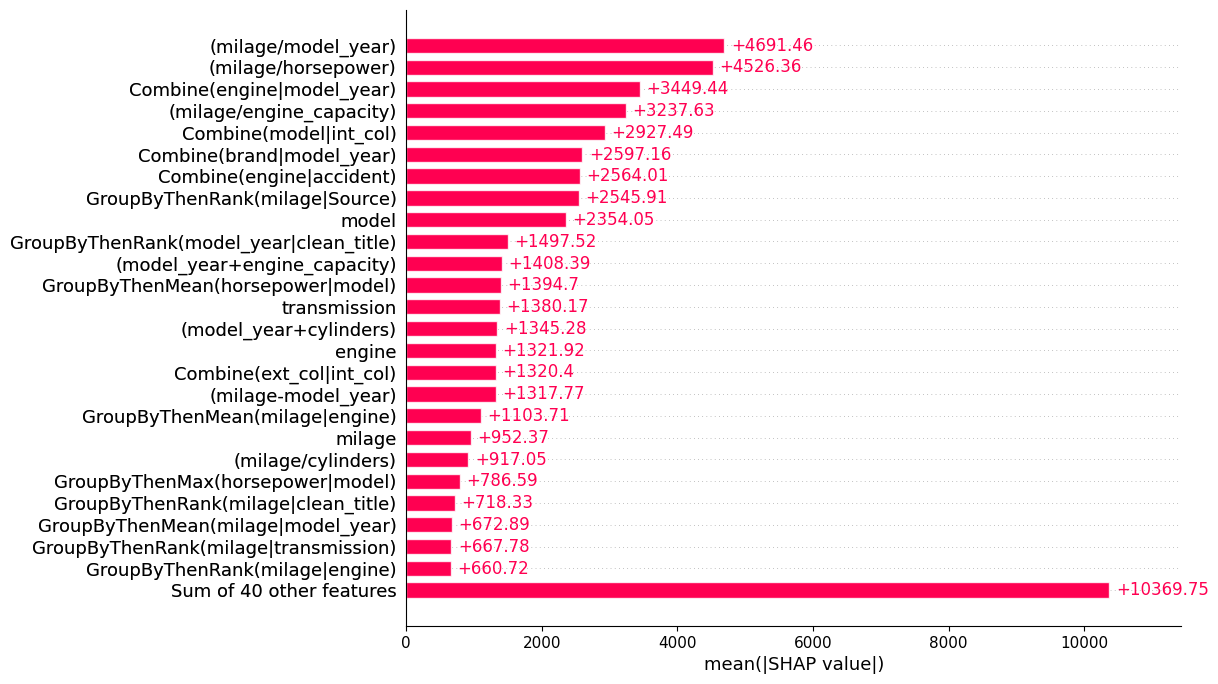

In [18]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer(x_train)

fig, ax=plt.subplots(figsize=(10,8))
shap.plots.bar(shap_values, max_display=26, ax=ax)


## Test Predictions

In [54]:
## set up submission format
submission = pd.read_csv('01_Data/sample_submission.csv')
submission['price'] = 0

,price_prediction
count,1.256900e+05
mean,4.383141e+04
std,4.101239e+04
min,-1.606588e+05
25%,1.882599e+04
50%,3.528053e+04
75%,5.548022e+04
max,1.697744e+06


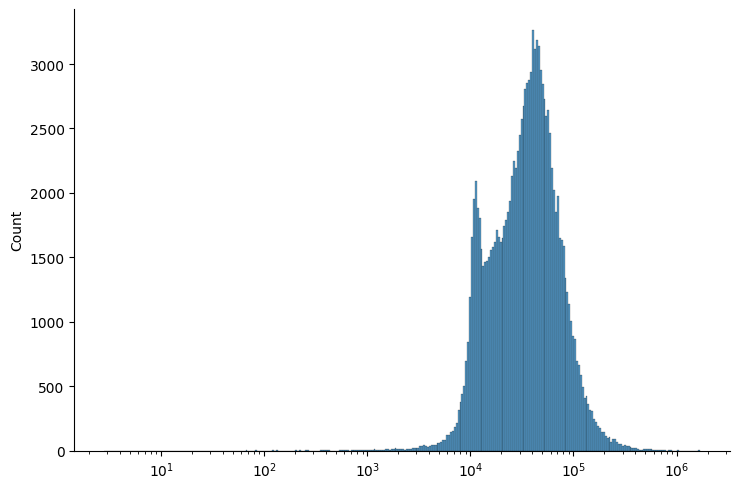

In [63]:
## lgbm prediction
y_testpred_lgbm = lgbm.predict(x_test)
submission['price'] = y_testpred_lgbm
# submission.to_csv('02_Submissions/test_pred_lgbm_v1.csv', index=False)

## check prediction distribution
sns.displot(y_testpred_lgbm, aspect=1.5, log_scale=True)
pd.DataFrame({'price_prediction':y_testpred_lgbm}).describe()